In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
import data.data_utils as dutils

Maxes: [6.99, 3.7500534695569394, 4.1520091466270985, 0.9972049387675246, 6.99, 4.642499226048113, 1.464969568906741, 3.5737442504051082, 6.99, 5.236144099845564, 3.667580574265431, 4.121005446707907, 6.99, 4.840954472645162, 3.7131037151583786, 3.6888081895250457]
Means: [0.7604354703393109, 0.09708994343473565, 0.42120700771937913, 0.8144428875680279, 0.16822840499086855, 0.7422497256728795, 0.020431389928808552, 0.9956448153679764, 0.6272029399319996, 0.10962207707944382, 0.9036783653066514, 0.3134219653903928, 0.06756367681015096, 0.5726111516542912, 0.6710567428358378, 0.9349511959589529] 
Sigmas: [0.2474040203655316, 0.21793173838978758, 0.02306119365910069, 0.484197933004595, 0.19182792770740761, 0.20787257454753288, 0.0774358678732376, 0.021494822555258287, 0.4152315633826085, 0.0207114961095407, 0.02426103583300874, 0.020476256815296363, 0.3715579384695712, 0.025095766072241316, 0.06250375802662107, 0.20037728201964605]
choice [array([0, 2, 1, 3]), array([6, 7, 4, 5]), array([

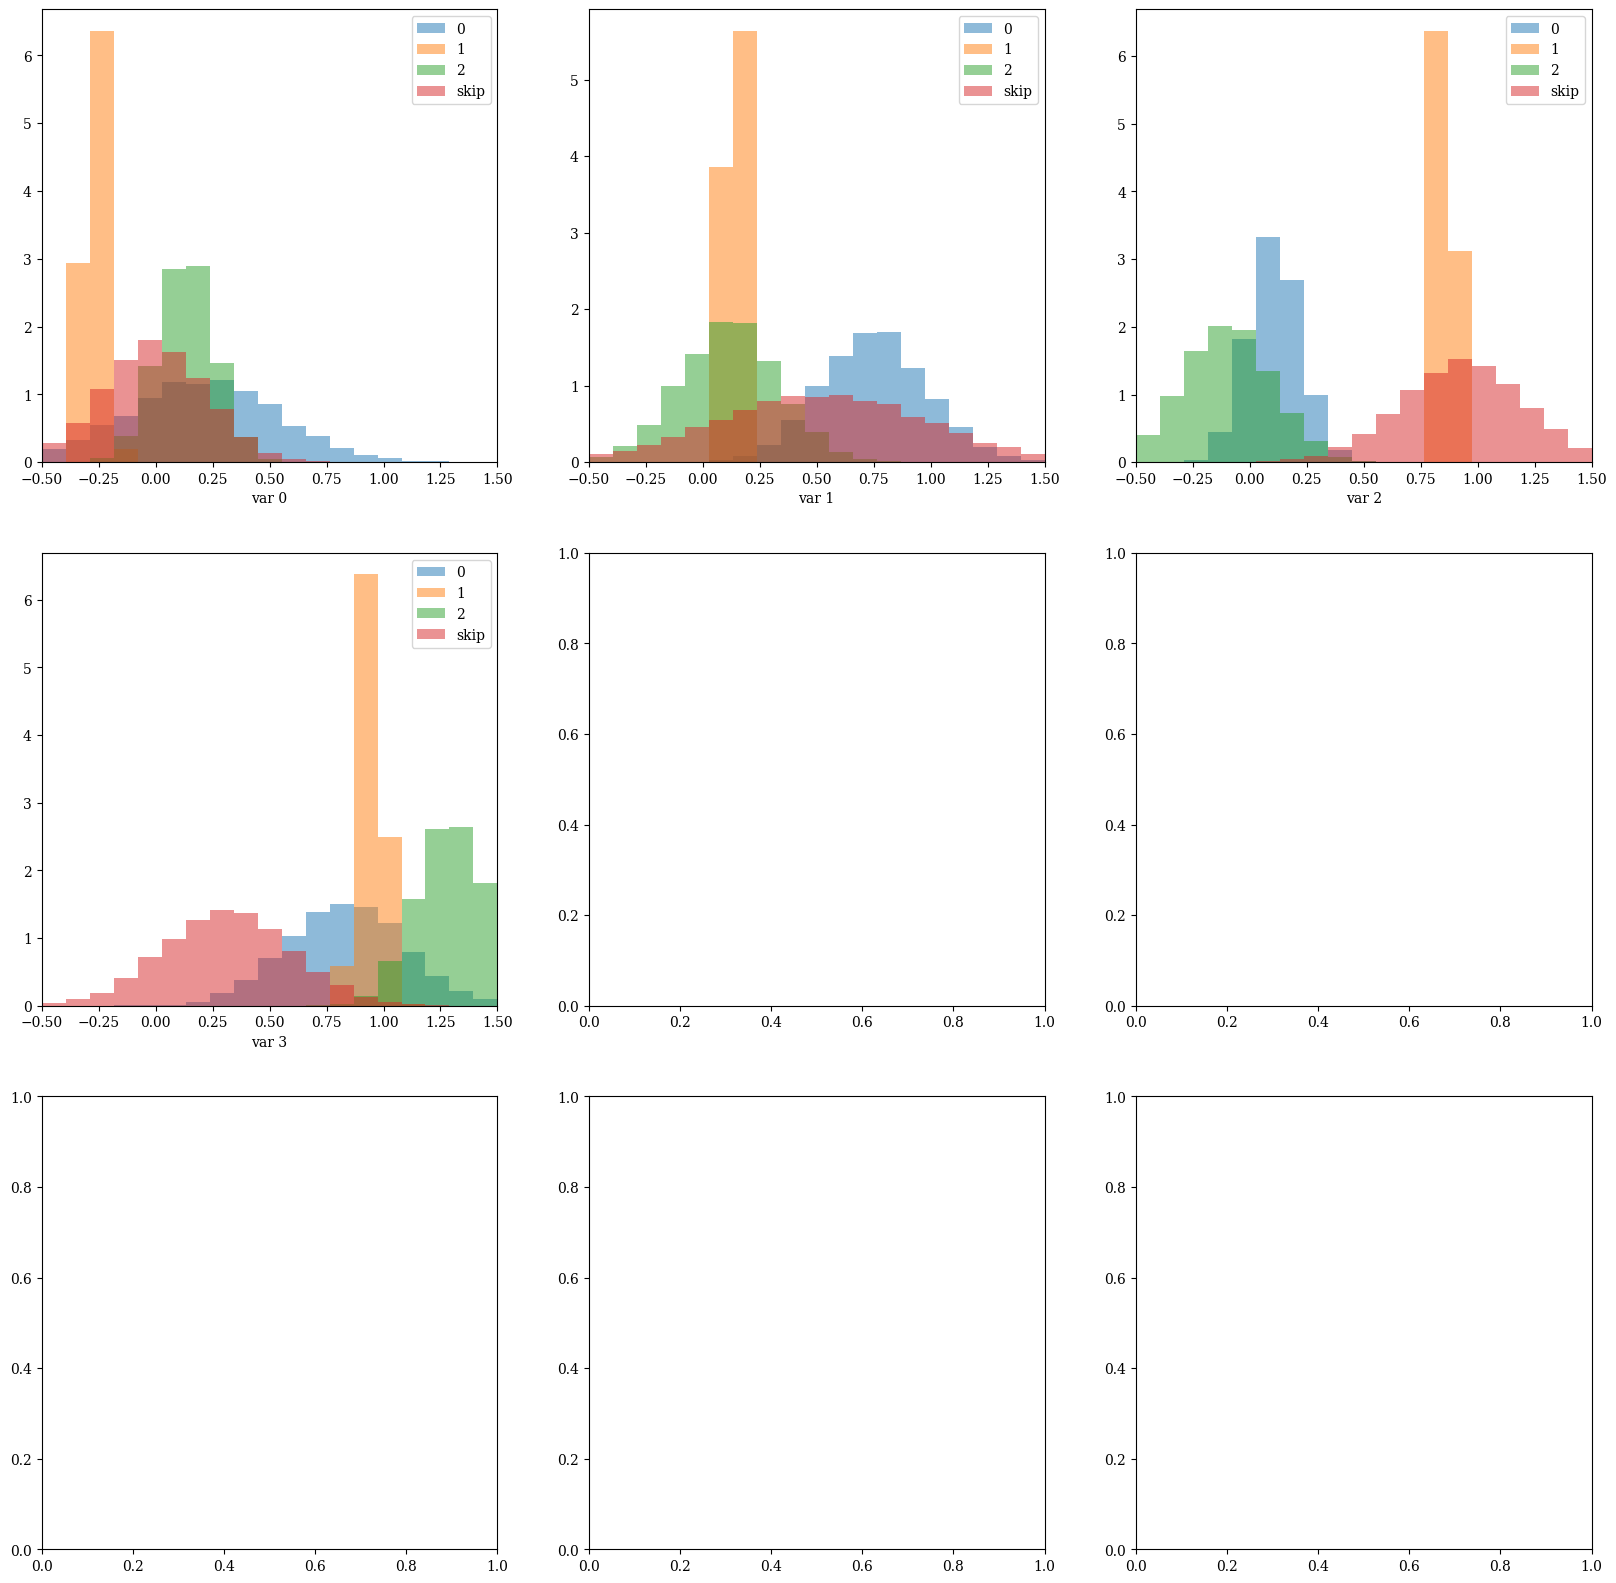

In [14]:
#np.random.seed(1000)
np.random.seed(999)
embed_dim=4
nsigs=4
ndisc=4
nrand=0
nj_train   = 10000
nj_valid   = 10000
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
tjds.plot()
torch.save(tjds,'flat_data_rand'+str(nrand)+'.pt')

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GP

Sanity Checking: |                                                                                            …

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.


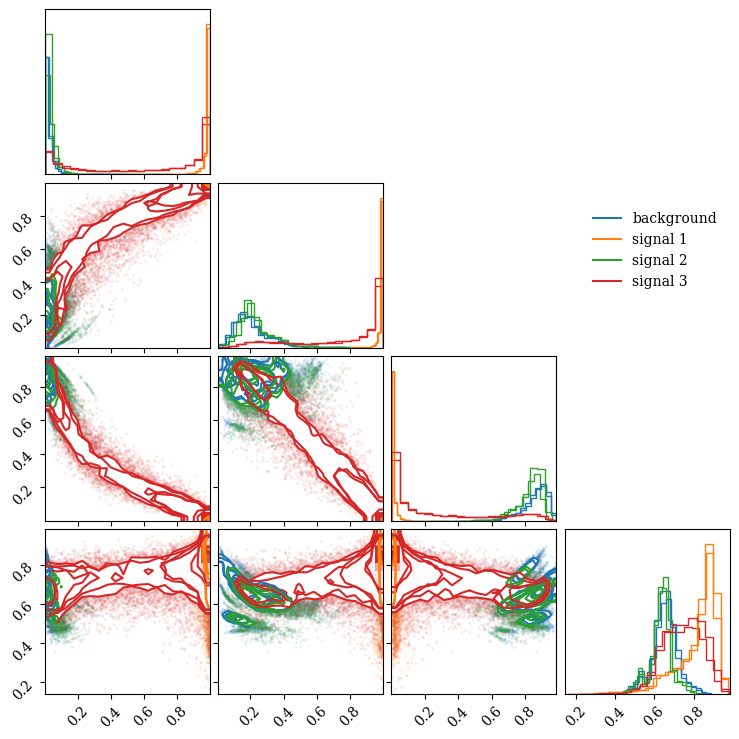

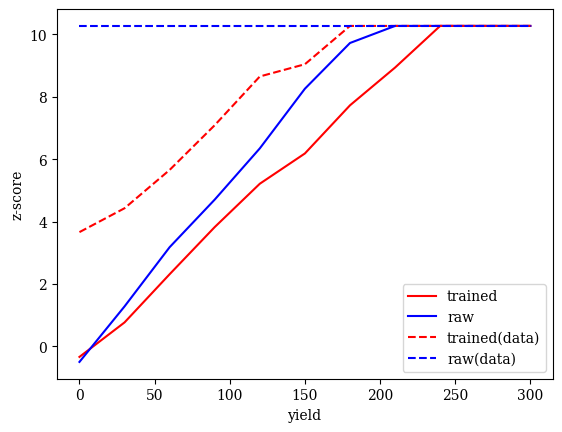

In [16]:
model_base,output_train,da_out,mc_out,_,_ =tjds.trainQuick(embed_dim=4,num_epochs=15,temp=0.1)
#torch.save(model_base, "model_baseline_"+str(nrand)+".pth")
#model_base = torch.load("model_baseline_"+str(nrand)+".pth")
#model_base,o11,o21,o31,_,_=tjds.trainQuickDataMC(imodel=model_base,embed_dim=embed_dim,num_epochs=5,temp=0.1,iMMD=False)
#model_base,o12,o22,o32,_,_=tjds.trainQuickDataMC(imodel=model_base,embed_dim=embed_dim,num_epochs=5,temp=0.5,iMMD=True)
#

/Users/philipharris/Dropbox/Physics/8S50_2022/test3/phlab-neurips25/experiments/toyjet/../../data/data_utils.py:849: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  i_out=torch.nn.functional.softmax(imodel.classifier(i_out)).numpy()


Epoch [1/5], Loss: 8.1829
Epoch [2/5], Loss: 8.0315
Epoch [3/5], Loss: 8.3018
Epoch [4/5], Loss: 8.1322
Epoch [5/5], Loss: 8.7517


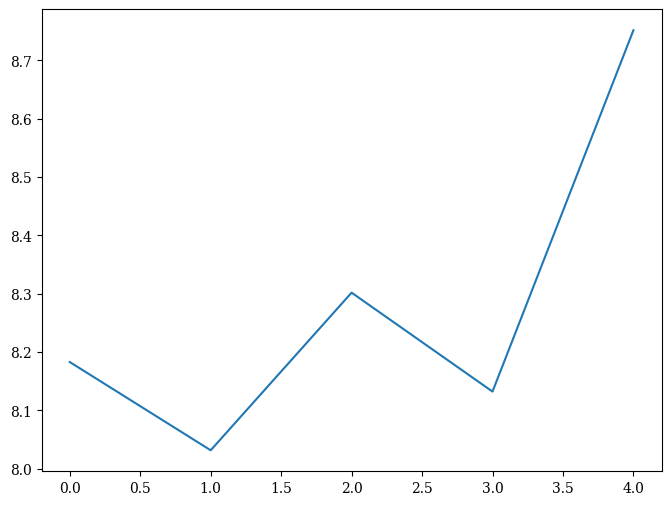

In [8]:
model_base = torch.load("model_baseline_"+str(nrand)+".pth")
train_sfree   = tjds.train_data  [tjds.train_labels != (nsigs-1)]
true_sfree    = tjds.true_data   [tjds.true_labels  != (nsigs-1)]
train_sfrel   = tjds.train_labels[tjds.train_labels != (nsigs-1)]
dutils.train_generic_datamc_prep(5,train_sfree,true_sfree,train_sfrel,model_base,cut_threshold=0.2,temp=0.5)
torch.save(model_base, "model_datamc_"+str(nrand)+".pth")

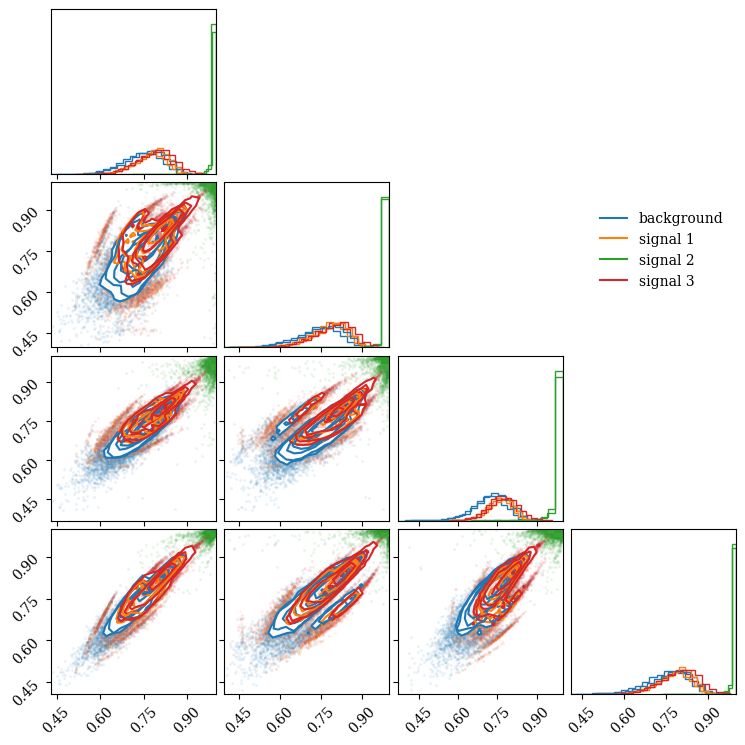

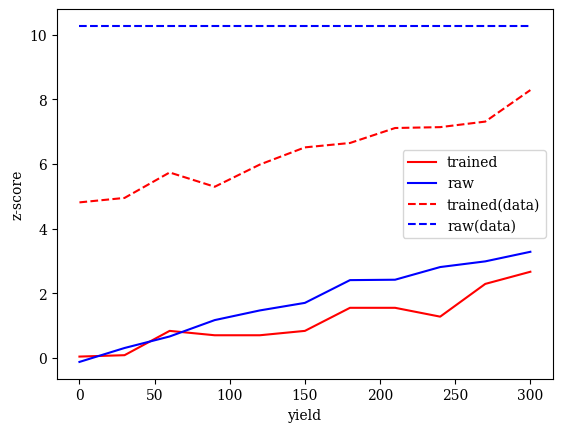

In [9]:
mc_lab=tjds.test_labels.int()
da_lab=tjds.trut_labels.int()
with torch.no_grad():
    mc_out  = (model_base(tjds.test_data.float(),embed=True))
    da_out  = (model_base(tjds.trut_data.float(),embed=True))

tjds.cornerQuick(mc_out,da_out,mc_lab,da_lab)
tjds.zscoreplot(mc_out,da_out,mc_lab,da_lab,tjds.test_data,tjds.trut_data,intoys=50)


Maxes: [6.99, 5.4239566437018985, 5.4600511794646085, 4.006637413438881, 6.99, 3.685275840557084, 4.84669305769382, 3.746329670085785, 6.99, 4.24555727953309, 6.203188931604334, 3.7348387592642256, 6.99, 6.829562421956614, 4.311508185289803, 3.698575731070242]
Means: [0.8301332108242423, 0.6007561326383023, 0.3249974862008397, 0.055190242300097725, 0.9812873983052343, 0.47909780898769394, 0.16314603232905678, 0.6786371784648596, 0.8181075360280037, 0.5264364876538992, 0.17064242788840644, 0.25645218937413106, 0.3783381148171018, 0.7928299455050453, 0.9453111049572496, 0.050975642922848174] 
Sigmas: [0.07428514326152787, 0.07821212131223898, 0.1636188980189544, 0.02467074874547752, 0.36691169577847116, 0.043207012930449, 0.10748345866836069, 0.02312653092130672, 0.10729972026156508, 0.08576248378497908, 0.4664285412054657, 0.02141492128807755, 0.14907120018289635, 0.07070212335810341, 0.02220130549184409, 0.06439524415623891]
choice [array([1, 2, 3, 0]), array([7, 4, 6, 5]), array([11, 

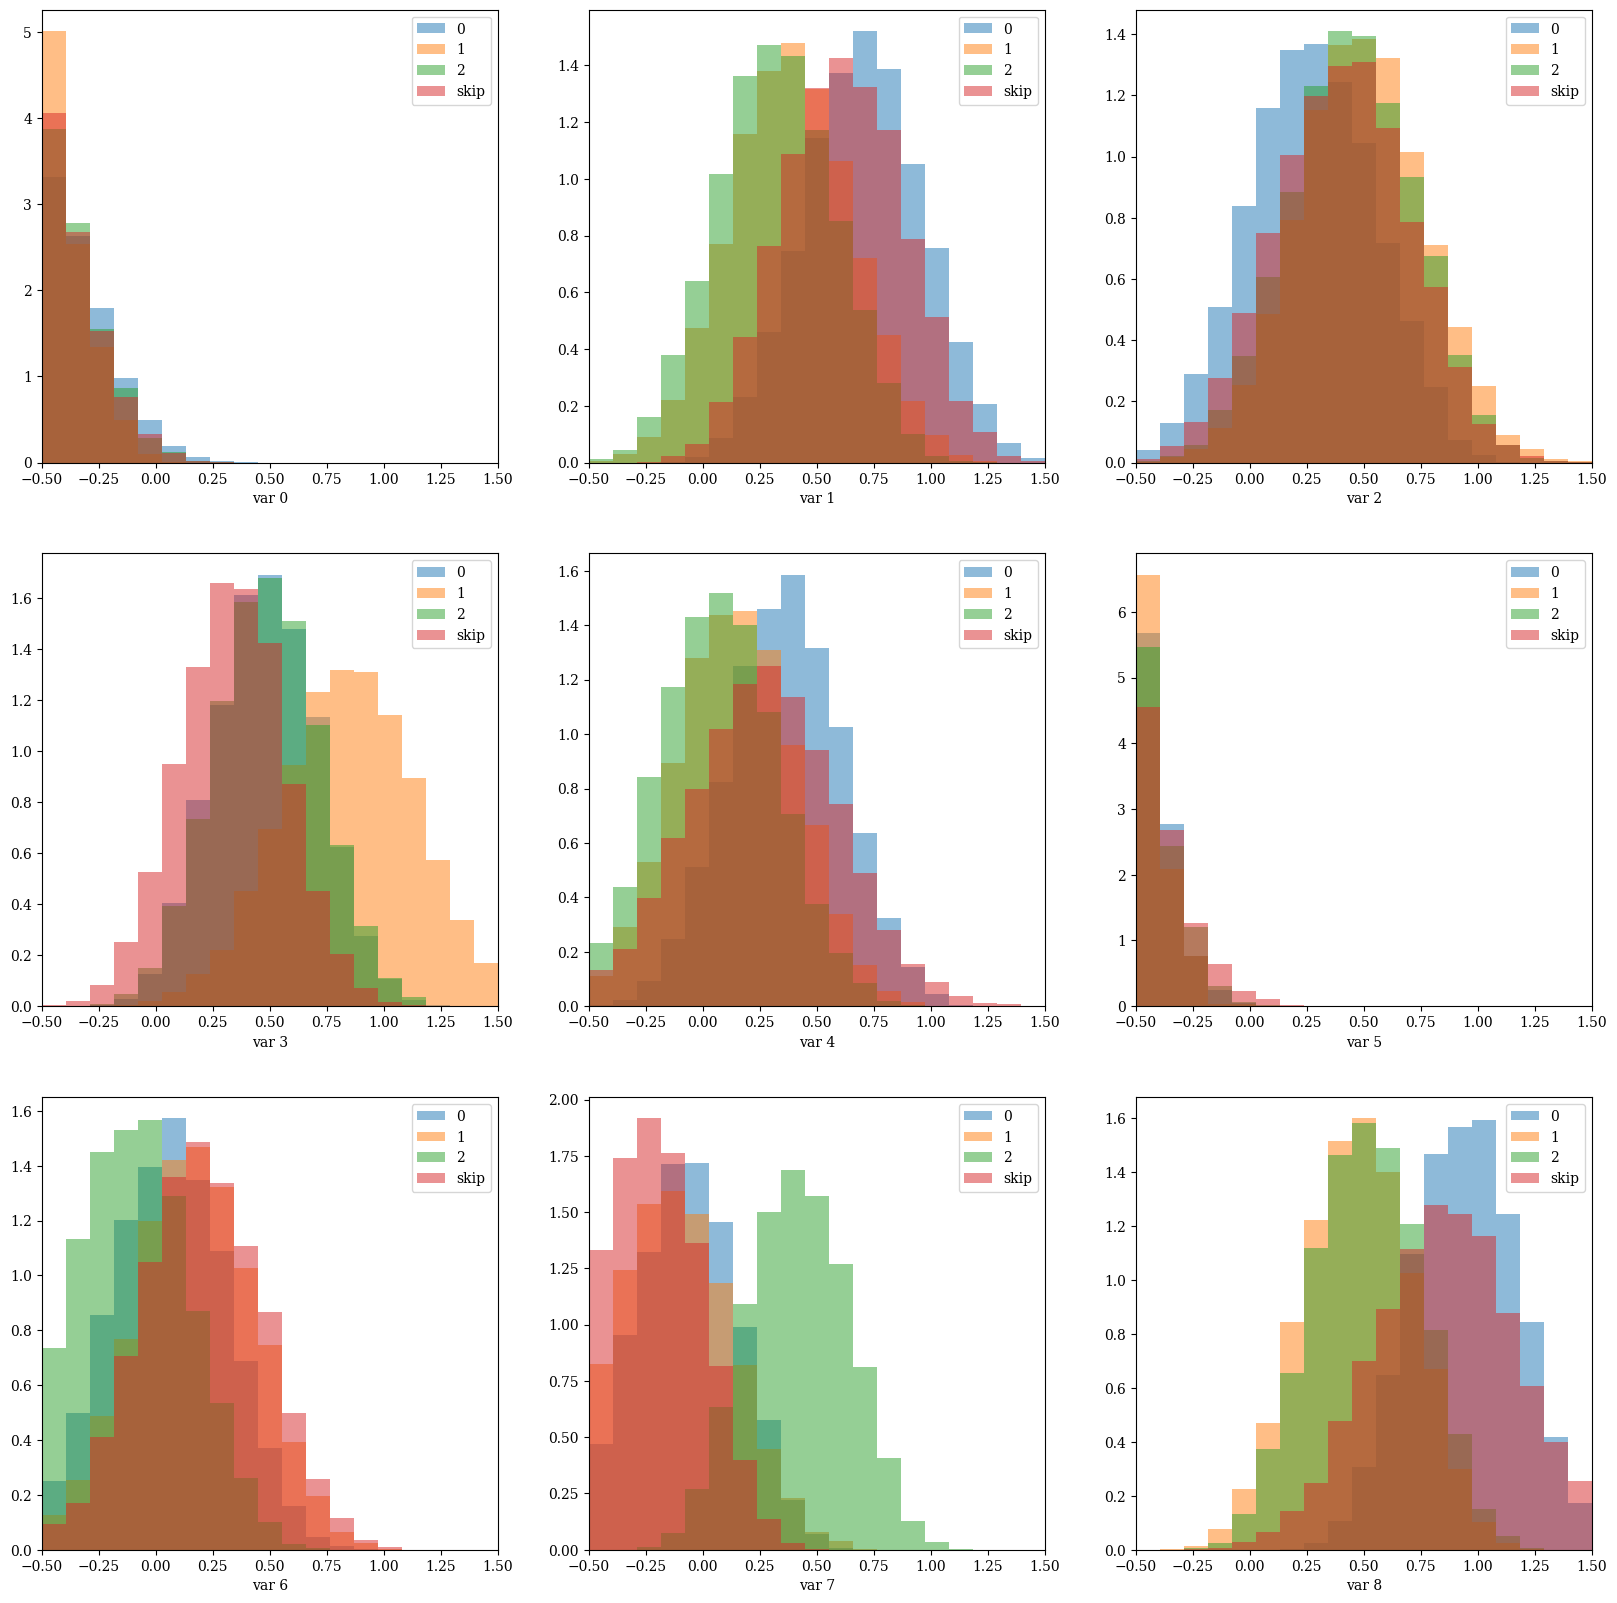

In [2]:
#np.random.seed(1000)
np.random.seed(999)
embed_dim=4
nsigs=4
ndisc=4
nrand=10
nj_train   = 10000
nj_valid   = 10000
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
tjds.plot()
torch.save(tjds,'flat_data_rand'+str(nrand)+'.pt')

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GP

Sanity Checking: |                                                                                            …

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.


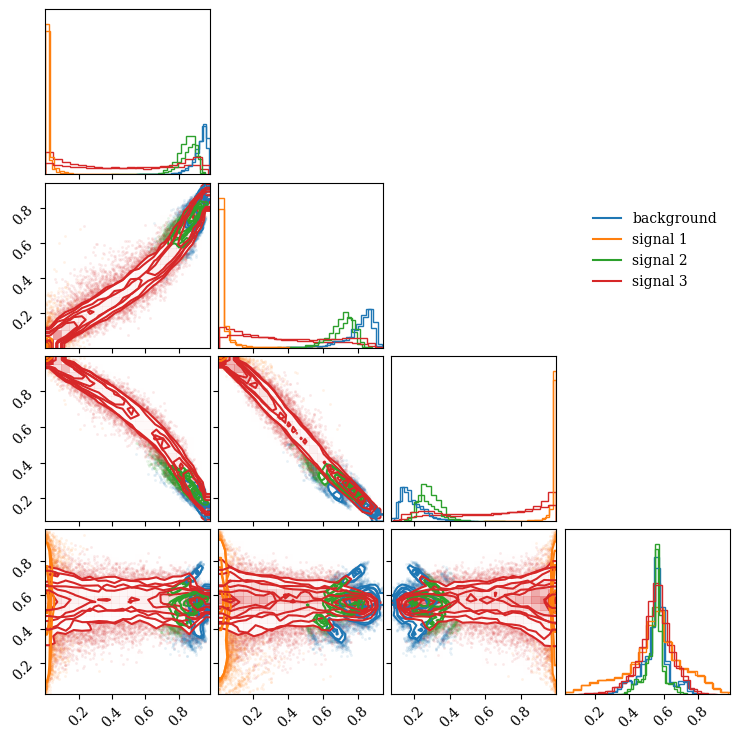

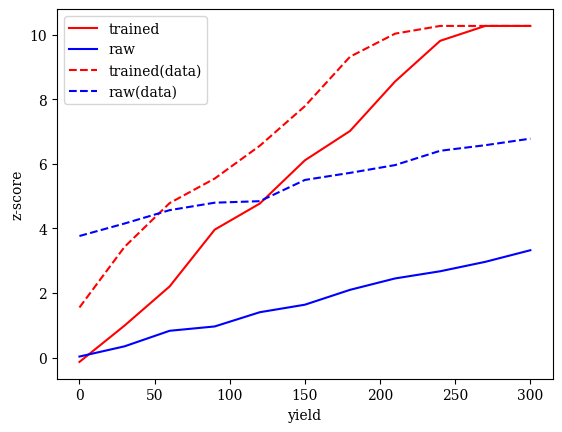

In [18]:
model_base,output_train,da_out,mc_out,_,_ =tjds.trainQuick(embed_dim=4,num_epochs=15,temp=0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.43it/s]


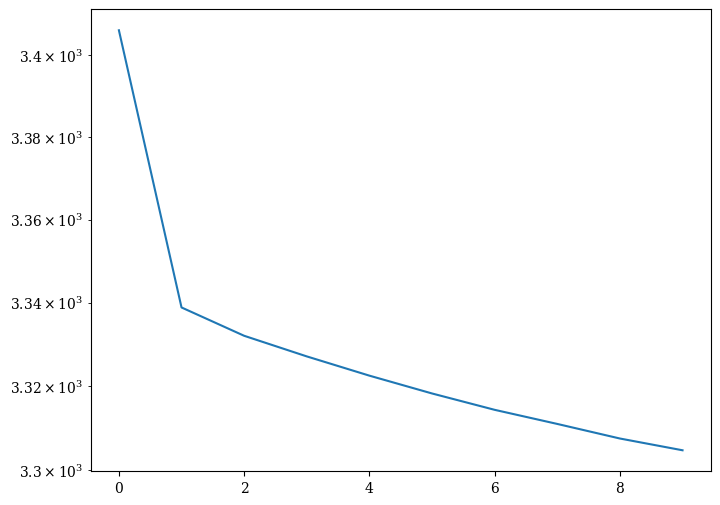

1
torch.Size([40000])
Accuracy: tensor(0.9969)


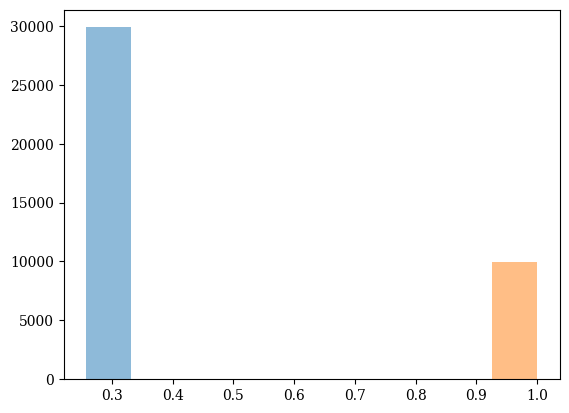

In [137]:
input_dim  = tjds.train_data.shape[1]
labels=tjds.train_labels
ntrain=10000
train_nosig = tjds.train_data[labels != (nsigs-1)]
train_sig   = tjds.train_data[labels == (nsigs-1)]

ntrain=np.max([ntrain,len(train_sig)])
ridx=torch.randperm(len(train_nosig))[:ntrain]
train_nosig=train_nosig[ridx]
train_comb = torch.cat((train_nosig,train_sig[0:ntrain]))
train_lab  = torch.cat((torch.zeros(ntrain),torch.ones(ntrain)))

dset=dutils.GenericDataset(train_comb,train_lab.long())
disc_trainloader = torch.utils.data.DataLoader(dset, batch_size=1000, shuffle=True)
disc_model=dutils.train_disc(10,disc_trainloader,input_dim,last_dim=8,output_dim=1)
plt.show()

dutils.check_disc(tjds.test_data,(tjds.test_labels == (nsigs-1)),disc_model)

In [ ]:
labels=tjds.test_labels
with torch.no_grad():
    output = (disc_model(tjds.test_data.float()))
#dutils.z_yield  (output, labels,  output,  labels, (nsigs-1),ntoys=100,iNb=10000,iNr=20000,plot=True, iOption=1)
dutils.run_toy(10,10000,20000,output,labels,output,labels,(nsigs-1),iOption=1,ntoys=1000)

In [47]:
arr = np.arange(20)
print(arr[-5:],arr)

[15 16 17 18 19] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [86]:
from scipy.stats import norm,chi2,kstest
chi2.sf(10,10)

0.44049328506521257

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]


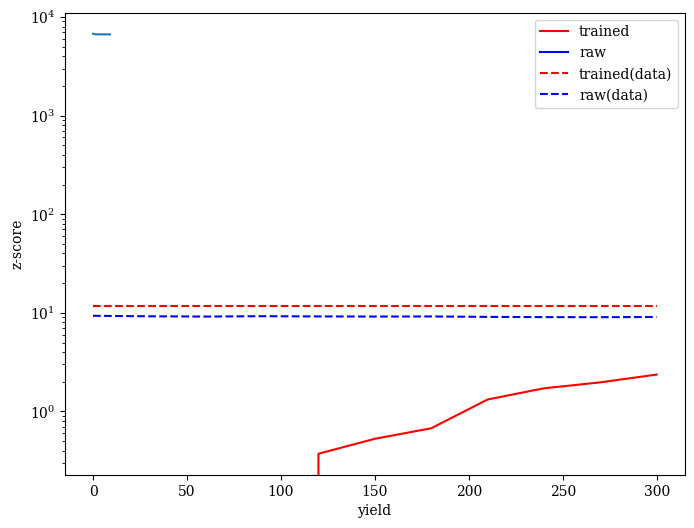

ValueError: not enough values to unpack (expected 6, got 5)

In [136]:
model_base,output_train,da_out,mc_out,_,_ =tjds.trainQuickDisc(last_dim=16,num_epochs=10,batch_size=1000,plot=True)
